In [63]:
import os

import cv2
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [2]:
path = os.path.dirname(r'C:\Users\HP\Desktop\project\Hand_digits\datasets\data_v2\train_data')
sub_folders = os.listdir(path)

sub_folders

['test_data', 'train_data', 'validation_data']

In [ ]:
def shuffle(images, labels):
    np.random.seed(42)
    indices = np.random.permutation(len(images))

    # Apply the same permutation to both
    images_shuffled = images[indices]
    labels_shuffled = labels[indices]
    return np.array(images_shuffled), np.array(labels_shuffled)

def get_data(path:str) -> list | list:
    # folder_set = os.listdir(path+f"\\{sub_folders[0]}") # test data
    folder_set = os.listdir(path)
    imgs = []
    labels = []

    for fs in folder_set: # 0 1 2 3 4 ...

        for img_file in os.listdir(path+f"\\{fs}"):
            img_path = path+f"\\{fs}\\{img_file}"
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,(128,128))    # resizing
            img = np.expand_dims(img, axis=-1)
            img = img.astype(np.float32)/255.0 # Normalization
            imgs.append(img)
            labels.append(fs)

    imgs, labels = shuffle(np.array(imgs), np.array(labels).astype(np.float32))
    return imgs, labels

In [19]:
train_imgs, train_labels = get_data(path+f'\\{sub_folders[1]}')
test_imgs, test_labels = get_data(path+f'\\{sub_folders[0]}')
validation_imgs, validation_labels = get_data(path+f'\\{sub_folders[2]}')

print(train_imgs.shape)
print(test_imgs.shape)
print(validation_imgs.shape)

(4504, 128, 128, 1)
(289, 128, 128, 1)
(108, 128, 128, 1)


In [20]:
train_labels[:20]

array([5., 6., 6., 2., 4., 8., 2., 2., 9., 2., 5., 8., 5., 8., 3., 5., 4.,
       8., 0., 5.], dtype=float32)

In [21]:
type(train_imgs)

numpy.ndarray

In [71]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

def with_augmented(original_imgs: np.array, original_labels: np.array):
    argument_imgs = []
    argument_labels = []

    argumented_data_generator = datagen.flow(original_imgs, original_labels, batch_size=256)
    for _ in range(30):
        imgs , labels = next(argumented_data_generator)
        argument_imgs.append(imgs)
        argument_labels.append(labels)

    argument_imgs = np.concatenate(argument_imgs, axis=0)
    argument_labels = np.concatenate(argument_labels, axis=0)

    original_imgs = np.concatenate([original_imgs, argument_imgs], axis=0)
    original_labels = np.concatenate([original_labels, argument_labels], axis=0)

    combined_imgs, combined_labels = shuffle(original_imgs, original_labels)

    return combined_imgs, combined_labels

In [72]:
train_imgs_with_aug , train_labels_with_aug = with_augmented(train_imgs, train_labels)
test_imgs_with_aug , test_labels_with_aug = with_augmented(test_imgs, test_labels)
validation_imgs_with_aug , validation_labels_with_aug = with_augmented(validation_imgs, validation_labels)

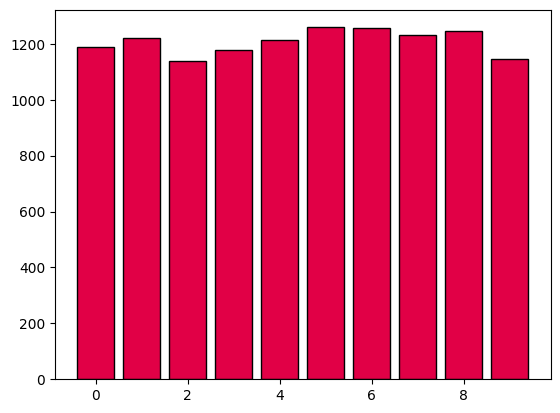

In [73]:
# Checking imbalancement
numbers, count = np.unique(train_labels_with_aug, return_counts=True)
plt.bar(numbers, count, color=[225/255,0,70/255], edgecolor='black')
plt.show()

In [74]:
train_imgs[0]

array([[[0.25490198],
        [0.21568628],
        [0.15294118],
        ...,
        [0.4862745 ],
        [0.48235294],
        [0.47843137]],

       [[0.25490198],
        [0.21568628],
        [0.14901961],
        ...,
        [0.45882353],
        [0.45882353],
        [0.45490196]],

       [[0.2509804 ],
        [0.21176471],
        [0.14509805],
        ...,
        [0.4117647 ],
        [0.41568628],
        [0.41568628]],

       ...,

       [[0.25882354],
        [0.23137255],
        [0.18431373],
        ...,
        [0.4       ],
        [0.39607844],
        [0.39215687]],

       [[0.2627451 ],
        [0.23137255],
        [0.1882353 ],
        ...,
        [0.45882353],
        [0.45490196],
        [0.4509804 ]],

       [[0.2627451 ],
        [0.23529412],
        [0.1882353 ],
        ...,
        [0.49019608],
        [0.4862745 ],
        [0.4862745 ]]], dtype=float32)

## Loading Model

In [75]:
model = keras.models.load_model(r'../Models/digits_classifier.keras')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,916,064 (37.83 MB)

 Trainable params: 3,305,354 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,610,710 (25.22 MB)

In [76]:
for layers in model.layers[:-3]: # freeze all the layers except the last 3
    layers.trainable = False

In [77]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(train_imgs_with_aug, train_labels_with_aug, epochs=25,
          validation_data=(validation_imgs_with_aug, validation_labels_with_aug), callbacks=[early_stopping])

Epoch 1/25
378/378 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - accuracy: 0.2143 - loss: 2.3529 - val_accuracy: 0.2832 - val_loss: 2.1257
Epoch 2/25
378/378 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - accuracy: 0.3615 - loss: 1.9493 - val_accuracy: 0.3426 - val_loss: 1.9699
Epoch 3/25
378/378 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.4275 - loss: 1.8166 - val_accuracy: 0.3993 - val_loss: 1.8926
Epoch 4/25
378/378 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - accuracy: 0.4643 - loss: 1.7678 - val_accuracy: 0.4421 - val_loss: 1.8287
Epoch 5/25
378/378 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.5017 - loss: 1.7307 - val_accuracy: 0.4585 - val_loss: 1.8192
Epoch 6/25
378/378 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.5114 - loss: 1.7117 - val_accuracy: 0.4576 - val_loss: 1.8221
Epoch 7/25
378/378 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - accuracy: 0.5163 - loss: 1.6900 - val_accuracy: 0.4597 - val_loss: 1.7854
Epoch 8/25
378/378 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.5267 - loss: 1

In [78]:
model.evaluate(test_imgs, test_labels)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.5750 - loss: 1.5537


[1.5849226713180542, 0.5432525873184204]

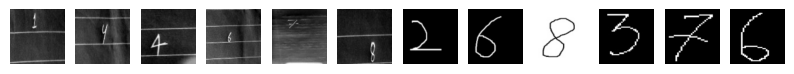

In [79]:
from glob import glob

pp_imgs = glob(r'..\PreProcessedImages\*.jpg')

imgs = []
for img in pp_imgs:
    img =cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    # Binarize and invert (threshold + inversion)
    # _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    img = np.invert(img)
    img = cv2.resize(img, (128,128))
    img = img.astype(np.float32)/255.0
    img = np.expand_dims(img, axis=-1)
    imgs.append(img)


imgs = np.array(imgs)
fig, axes = plt.subplots(1,len(imgs), figsize=(10,10))
for i in range(len(imgs)):
    axes[i].imshow(imgs[i], cmap='gray')
    axes[i].axis('off')

In [80]:
[int(i.argmax()) for i in model.predict(imgs)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


[3, 3, 3, 3, 3, 3, 0, 8, 8, 8, 8, 6]

In [81]:
model.save(filepath=r'C:\Users\HP\Desktop\project\Hand_digits\Models\fine_tunned_classifier.keras')